# U.S. Cities and Towns

This notebook contains scripts that generate a dataset of U.S. places, like cities and towns, based on the data from the U.S. Census Bureau. The generated dataset has the following structure:

* `GEOID` - geographical unique identifier of the place (city or town) in the U.S. Census Bureau format.
* `NAME` - a name of the place.
* `STUSPS` - two-symbol USPS state abbreviation.
* `NAMELSAD` - a name of the place with its LSAD type.
* `NAMEST` - a full name of the place, including state abbreviation.
* `FUNCSTAT` - functional status of the place.
* `ALAND` - land area of the place.
* `AWATER` - water area of the place.
* `INTPTLAT` - the geographical latitude of the place.
* `INTPTLON` - the geographical longitude of the place.
* `POPBASE` - the place population according to the latest census survey.
* `POPPREV` - the place population according to the previous census survey.
* `POPEST` - the estimated current place population.
* `POPDOD` - decade-over-decade population change (between previous and the latest census surveys).
* `POPBTD` - base-to-date population change (between the latest census survey and current estimate).

In [1]:
'''
This document retrieves and prepares the places database from the U.S. Census.
'''

DOWNLOAD = False
GEODATA_YEAR = "2022"
GEODATA_BASE_URI = "https://www2.census.gov/geo/tiger"

POPULATION_SURVEYS_PREVIOUS_YEAR = "2010"
POPULATION_SURVEYS_BASE_YEAR = "2020"
POPULATION_SURVEYS_ESTIMATE_YEAR = "2021"
POPULATION_SURVEYS_BASE_URI = "https://www2.census.gov/programs-surveys/popest/datasets"

INBOUND_PATH = "../data/inbound/geo"
OUTBOUND_PATH = "../data/outbound/geo"

In [2]:
'''
Define U.S. regions.
'''

new_england         = ["CT", "ME", "MA", "NH", "RI", "VT"]
middle_atlantic     = ["NJ", "NY", "PA"]
east_north_central  = ["IN", "IL", "MI", "OH", "WI"]
west_north_central  = ["IA", "KS", "MN", "MO", "NE", "ND", "SD"]
south_atlantic      = ["DE", "DC", "FL", "GA", "MD", "NC", "SC", "VA", "WV"]
east_south_central  = ["AL", "KY", "MS", "TN"]
west_south_central  = ["AR", "LA", "OK", "TX"]
mountain            = ["AZ", "CO", "ID", "NM", "MT", "UT", "NV", "WY"]
pacific             = ["CA", "OR", "WA"]
ocean               = ["AK", "HI"]

northeast           = new_england + middle_atlantic
midwest             = east_north_central + west_north_central
south               = south_atlantic + east_south_central + west_south_central
west                = mountain + pacific
continental         = northeast + midwest + south + west

In [3]:
'''
Import dependencies.
'''

import os
import math
import wget
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from pandas.api.types import CategoricalDtype
from urllib.error import HTTPError


In [4]:
'''
Download and initialize states dataframe.
'''

filename = "tl_" + GEODATA_YEAR + "_us_state"

if DOWNLOAD:
    # download dataset
    source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/STATE/" + filename + ".zip"
    dest = INBOUND_PATH + "/" + filename + ".zip"
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)
    # unzip dataset
    with zipfile.ZipFile(dest, 'r') as zip_ref:
        zip_ref.extractall(INBOUND_PATH)
    # cleanup
    os.remove(dest)

# create dataframe
states = gpd.read_file(INBOUND_PATH + "/" + filename + ".dbf")

# drop unnecessary columns
states = states.drop(
    [
        "REGION", "DIVISION", 
        "GEOID", "STATENS", "NAME", 
        "LSAD", "MTFCC", "FUNCSTAT", 
        "ALAND", "AWATER", 
        "INTPTLAT", "INTPTLON"
    ],
    axis=1
)

# normalize field types
states["STATEFP"] = states["STATEFP"].astype("string")
states["STUSPS"] = states["STUSPS"].astype("string")

states.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   56 non-null     string  
 1   STUSPS    56 non-null     string  
 2   geometry  56 non-null     geometry
dtypes: geometry(1), string(2)
memory usage: 1.4 KB


In [5]:
'''
Download and initialize places dataframe.
'''

def create_places_df(state_id):
    
    '''
    Downloads a dataset of places for a given state ID 
    and creates a dataframe from it.
    '''
    
    filename = "tl_" + GEODATA_YEAR + "_" + state_id + "_place"
    
    if DOWNLOAD:
        # download dataset
        source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/PLACE/" + filename + ".zip"
        dest = INBOUND_PATH + "/" + filename + ".zip"
        if os.path.exists(dest):
            os.remove(dest)
        wget.download(source, dest)
        # unzip dataset
        with zipfile.ZipFile(dest, 'r') as zip_ref:
            zip_ref.extractall(INBOUND_PATH)
        # cleanup
        os.remove(dest)
    
    # create dataframe
    return gpd.read_file(INBOUND_PATH + "/" + filename + ".dbf")

# concat dataframes from different files
places = pd.concat((create_places_df(state_id) for state_id in states["STATEFP"]))

# drop unnecessary columns
places = places.drop(
    [
        "PLACEFP", "PLACENS", "LSAD",
        "CLASSFP", "PCICBSA", "PCINECTA", 
        "MTFCC", "geometry"
    ],
    axis=1
)

# normalize field types
places["GEOID"] = places["GEOID"].astype("int32")
places["STATEFP"] = places["STATEFP"].astype("string")
places["NAME"] = places["NAME"].astype("string")
places["NAMELSAD"] = places["NAMELSAD"].astype("string")
places["FUNCSTAT"] = places["FUNCSTAT"].astype(CategoricalDtype(ordered=False))
places["INTPTLAT"] = places["INTPTLAT"].map(np.float64)
places["INTPTLON"] = places["INTPTLON"].map(np.float64)

places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32466 entries, 0 to 466
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   32466 non-null  string  
 1   GEOID     32466 non-null  int32   
 2   NAME      32466 non-null  string  
 3   NAMELSAD  32466 non-null  string  
 4   FUNCSTAT  32466 non-null  category
 5   ALAND     32466 non-null  int64   
 6   AWATER    32466 non-null  int64   
 7   INTPTLAT  32466 non-null  float64 
 8   INTPTLON  32466 non-null  float64 
dtypes: category(1), float64(2), int32(1), int64(2), string(3)
memory usage: 2.1 MB


In [6]:
'''
Download and initialize consolidated cities dataframe.
'''

def create_cities_df(state_id):
    
    '''
    Downloads a dataset of consolidated cities for a given state ID 
    and creates a dataframe from it.
    '''
    
    filename = "tl_" + GEODATA_YEAR + "_" + state_id + "_concity"
    
    try:
        if DOWNLOAD:
            # download dataset
            source = GEODATA_BASE_URI + "/TIGER" + GEODATA_YEAR + "/CONCITY/" + filename + ".zip"
            dest = INBOUND_PATH + "/" + filename + ".zip"
            if os.path.exists(dest):
                os.remove(dest)

            wget.download(source, dest)
            # unzip dataset
            with zipfile.ZipFile(dest, 'r') as zip_ref:
                zip_ref.extractall(INBOUND_PATH)
            # cleanup
            os.remove(dest)
        # create dataframe
        return gpd.read_file(INBOUND_PATH + "/" + filename + ".dbf")
    except:
        pass

# concat dataframes from different files
cities = pd.concat((create_cities_df(state_id) for state_id in states["STATEFP"]))

# drop unnecessary columns
cities = cities.drop(
    [
        "CONCTYFP", "CONCTYNS", "LSAD",
        "CLASSFP", "MTFCC", "geometry"
    ],
    axis=1
)

# normalize field types
cities["GEOID"] = cities["GEOID"].astype("int32")
cities["STATEFP"] = cities["STATEFP"].astype("string")
cities["NAME"] = cities["NAME"].astype("string")
cities["NAMELSAD"] = cities["NAMELSAD"].astype("string")
cities["FUNCSTAT"] = cities["FUNCSTAT"].astype(CategoricalDtype(ordered=False))
cities["INTPTLAT"] = cities["INTPTLAT"].map(np.float64)
cities["INTPTLON"] = cities["INTPTLON"].map(np.float64)

cities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8 entries, 0 to 0
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   8 non-null      string  
 1   GEOID     8 non-null      int32   
 2   NAME      8 non-null      string  
 3   NAMELSAD  8 non-null      string  
 4   FUNCSTAT  8 non-null      category
 5   ALAND     8 non-null      int64   
 6   AWATER    8 non-null      int64   
 7   INTPTLAT  8 non-null      float64 
 8   INTPTLON  8 non-null      float64 
dtypes: category(1), float64(2), int32(1), int64(2), string(3)
memory usage: 668.0 bytes


In [7]:
'''
Concatenate places and consolidated cities.
'''
places = pd.concat([places, cities])
places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32474 entries, 0 to 0
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   STATEFP   32474 non-null  string 
 1   GEOID     32474 non-null  int32  
 2   NAME      32474 non-null  string 
 3   NAMELSAD  32474 non-null  string 
 4   FUNCSTAT  32474 non-null  object 
 5   ALAND     32474 non-null  int64  
 6   AWATER    32474 non-null  int64  
 7   INTPTLAT  32474 non-null  float64
 8   INTPTLON  32474 non-null  float64
dtypes: float64(2), int32(1), int64(2), object(1), string(3)
memory usage: 2.4+ MB


In [8]:
'''
Merge places and states.
'''

places = pd.merge(places, states, left_on="STATEFP", right_on="STATEFP", how="left")

# generate place name with state
places["NAMEST"] = (places["NAME"] + ", " + places["STUSPS"]).astype("string")

# drop unnecessary columns
places = places.drop(["STATEFP", "geometry"], axis=1)

places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32474 entries, 0 to 32473
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GEOID     32474 non-null  int32  
 1   NAME      32474 non-null  string 
 2   NAMELSAD  32474 non-null  string 
 3   FUNCSTAT  32474 non-null  object 
 4   ALAND     32474 non-null  int64  
 5   AWATER    32474 non-null  int64  
 6   INTPTLAT  32474 non-null  float64
 7   INTPTLON  32474 non-null  float64
 8   STUSPS    32474 non-null  string 
 9   NAMEST    32474 non-null  string 
dtypes: float64(2), int32(1), int64(2), object(1), string(4)
memory usage: 2.6+ MB


In [9]:
'''
Download and initialize population estimates dataframe.
'''

filename = "sub-est" + POPULATION_SURVEYS_ESTIMATE_YEAR + "_all" + ".csv"
source = POPULATION_SURVEYS_BASE_URI + "/" + POPULATION_SURVEYS_BASE_YEAR + "-" + POPULATION_SURVEYS_ESTIMATE_YEAR + "/cities/totals/" + filename
dest = INBOUND_PATH + "/" + filename

if DOWNLOAD:
    # download dataset
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
population = pd.read_csv(dest, encoding="ISO-8859-1")

# drop duplicates
population = population[population["PRIMGEO_FLAG"] == 1]

# generate GEOID
population["GEOID"] = (population["STATE"].astype("string") + population["PLACE"].apply(lambda code: "{:05d}".format(code))).map(np.int32)

# drop unnecessary columns
population = population[[
    "GEOID",
    "ESTIMATESBASE" + POPULATION_SURVEYS_BASE_YEAR,
    "POPESTIMATE" + POPULATION_SURVEYS_ESTIMATE_YEAR,
]]

# rename columns
population = population.rename(columns={
    "ESTIMATESBASE" + POPULATION_SURVEYS_BASE_YEAR: "POPBASE",
    "POPESTIMATE" + POPULATION_SURVEYS_ESTIMATE_YEAR: "POPEST",
})

# Some places like cities and towns may belong to different counties. It leads to 
# multiple records with the same GEOID in the population dataframe. We have to group 
# them, summing populations.
population = population.groupby("GEOID", as_index=False).sum()

# calculate base-to-date estimated population growth
population["POPBTD"] = population["POPEST"]/population["POPBASE"] - 1

population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19568 entries, 0 to 19567
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GEOID    19568 non-null  int32  
 1   POPBASE  19568 non-null  int64  
 2   POPEST   19568 non-null  int64  
 3   POPBTD   19560 non-null  float64
dtypes: float64(1), int32(1), int64(2)
memory usage: 535.2 KB


In [10]:
'''
Download and initialize previous population survey dataframe.
'''

filename = "SUB-EST" + POPULATION_SURVEYS_BASE_YEAR + "_ALL" + ".csv"
source = POPULATION_SURVEYS_BASE_URI + "/" + POPULATION_SURVEYS_PREVIOUS_YEAR + "-" + POPULATION_SURVEYS_BASE_YEAR + "/cities/" + filename
dest = INBOUND_PATH + "/" + filename

if DOWNLOAD:
    # download dataset
    if os.path.exists(dest):
        os.remove(dest)
    wget.download(source, dest)

# create dataframe
previous_population = pd.read_csv(dest, encoding="ISO-8859-1")

# drop duplicates
previous_population = previous_population[previous_population["PRIMGEO_FLAG"] == 1]

# generate GEOID
previous_population["GEOID"] = (previous_population["STATE"].astype("string") + previous_population["PLACE"].apply(lambda code: "{:05d}".format(code))).map(np.int32)

# drop unnecessary columns
previous_population = previous_population[[
    "GEOID",
    "ESTIMATESBASE" + POPULATION_SURVEYS_PREVIOUS_YEAR,
]]

# rename columns
previous_population = previous_population.rename(columns={
    "ESTIMATESBASE" + POPULATION_SURVEYS_PREVIOUS_YEAR: "POPPREV",
})

# Some places like cities and towns may belong to different counties. It leads to 
# multiple records with the same GEOID in the population dataframe. We have to group 
# them, summing populations.
previous_population = previous_population.groupby("GEOID", as_index=False).sum()

previous_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19568 entries, 0 to 19567
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   GEOID    19568 non-null  int32
 1   POPPREV  19568 non-null  int64
dtypes: int32(1), int64(1)
memory usage: 229.4 KB


In [11]:
'''
Merge current survey population dataframe with previous survey population dataframe
'''

population = pd.merge(
    population,
    previous_population,
    left_on="GEOID", 
    right_on="GEOID", 
    how="left"
)

# calculate decade-over-decade population growth
population["POPDOD"] = population["POPBASE"]/population["POPPREV"] - 1

population.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19568 entries, 0 to 19567
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GEOID    19568 non-null  int32  
 1   POPBASE  19568 non-null  int64  
 2   POPEST   19568 non-null  int64  
 3   POPBTD   19560 non-null  float64
 4   POPPREV  19552 non-null  float64
 5   POPDOD   19551 non-null  float64
dtypes: float64(3), int32(1), int64(2)
memory usage: 993.7 KB


In [12]:
'''
Merge places and population.
'''

places = pd.merge(
    places, 
    population,
    left_on="GEOID", 
    right_on="GEOID", 
    how="left"
)

# normalize field types
places["POPBASE"] = places["POPBASE"].astype("Int64")
places["POPPREV"] = places["POPPREV"].astype("Int64")
places["POPEST"] = places["POPEST"].astype("Int64")

places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32474 entries, 0 to 32473
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GEOID     32474 non-null  int32  
 1   NAME      32474 non-null  string 
 2   NAMELSAD  32474 non-null  string 
 3   FUNCSTAT  32474 non-null  object 
 4   ALAND     32474 non-null  int64  
 5   AWATER    32474 non-null  int64  
 6   INTPTLAT  32474 non-null  float64
 7   INTPTLON  32474 non-null  float64
 8   STUSPS    32474 non-null  string 
 9   NAMEST    32474 non-null  string 
 10  POPBASE   19486 non-null  Int64  
 11  POPEST    19486 non-null  Int64  
 12  POPBTD    19478 non-null  float64
 13  POPPREV   19470 non-null  Int64  
 14  POPDOD    19469 non-null  float64
dtypes: Int64(3), float64(4), int32(1), int64(2), object(1), string(4)
memory usage: 3.9+ MB


In [13]:
'''
Rearrange columns.
'''

places = places[[
    "GEOID",
    "NAME",
    "STUSPS",
    "NAMELSAD",
    "NAMEST",
    "FUNCSTAT",
    "ALAND",
    "AWATER",
    "INTPTLAT",
    "INTPTLON",
    "POPBASE",
    "POPPREV",
    "POPEST",
    "POPDOD",
    "POPBTD",
]]

places.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32474 entries, 0 to 32473
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   GEOID     32474 non-null  int32  
 1   NAME      32474 non-null  string 
 2   STUSPS    32474 non-null  string 
 3   NAMELSAD  32474 non-null  string 
 4   NAMEST    32474 non-null  string 
 5   FUNCSTAT  32474 non-null  object 
 6   ALAND     32474 non-null  int64  
 7   AWATER    32474 non-null  int64  
 8   INTPTLAT  32474 non-null  float64
 9   INTPTLON  32474 non-null  float64
 10  POPBASE   19486 non-null  Int64  
 11  POPPREV   19470 non-null  Int64  
 12  POPEST    19486 non-null  Int64  
 13  POPDOD    19469 non-null  float64
 14  POPBTD    19478 non-null  float64
dtypes: Int64(3), float64(4), int32(1), int64(2), object(1), string(4)
memory usage: 3.9+ MB


In [14]:
places.head()

,GEOID,NAME,STUSPS,NAMELSAD,NAMEST,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,POPBASE,POPPREV,POPEST,POPDOD,POPBTD
0,5437372,Hillsboro,WV,Hillsboro town,"Hillsboro, WV",A,1379934,0,38.138381,-80.210696,232,253,231,-0.083004,-0.004310
1,5463292,Philippi,WV,Philippi city,"Philippi, WV",A,7327198,237303,39.147292,-80.050381,2928,2954,2922,-0.008802,-0.002049
2,5422852,Durbin,WV,Durbin town,"Durbin, WV",A,1481529,0,38.547126,-79.827822,235,294,240,-0.200680,0.021277
3,5415676,Clay,WV,Clay town,"Clay, WV",A,1444683,147764,38.461457,-81.084910,399,491,387,-0.187373,-0.030075
4,5467108,Ravenswood,WV,Ravenswood city,"Ravenswood, WV",A,4706719,184452,38.956291,-81.761981,3865,3846,3847,0.004940,-0.004657


In [15]:
'''
Store to CSV.
'''

places.to_csv(OUTBOUND_PATH + "/us_places.csv", index=False)

<AxesSubplot: xlabel='INTPTLON', ylabel='INTPTLAT'>

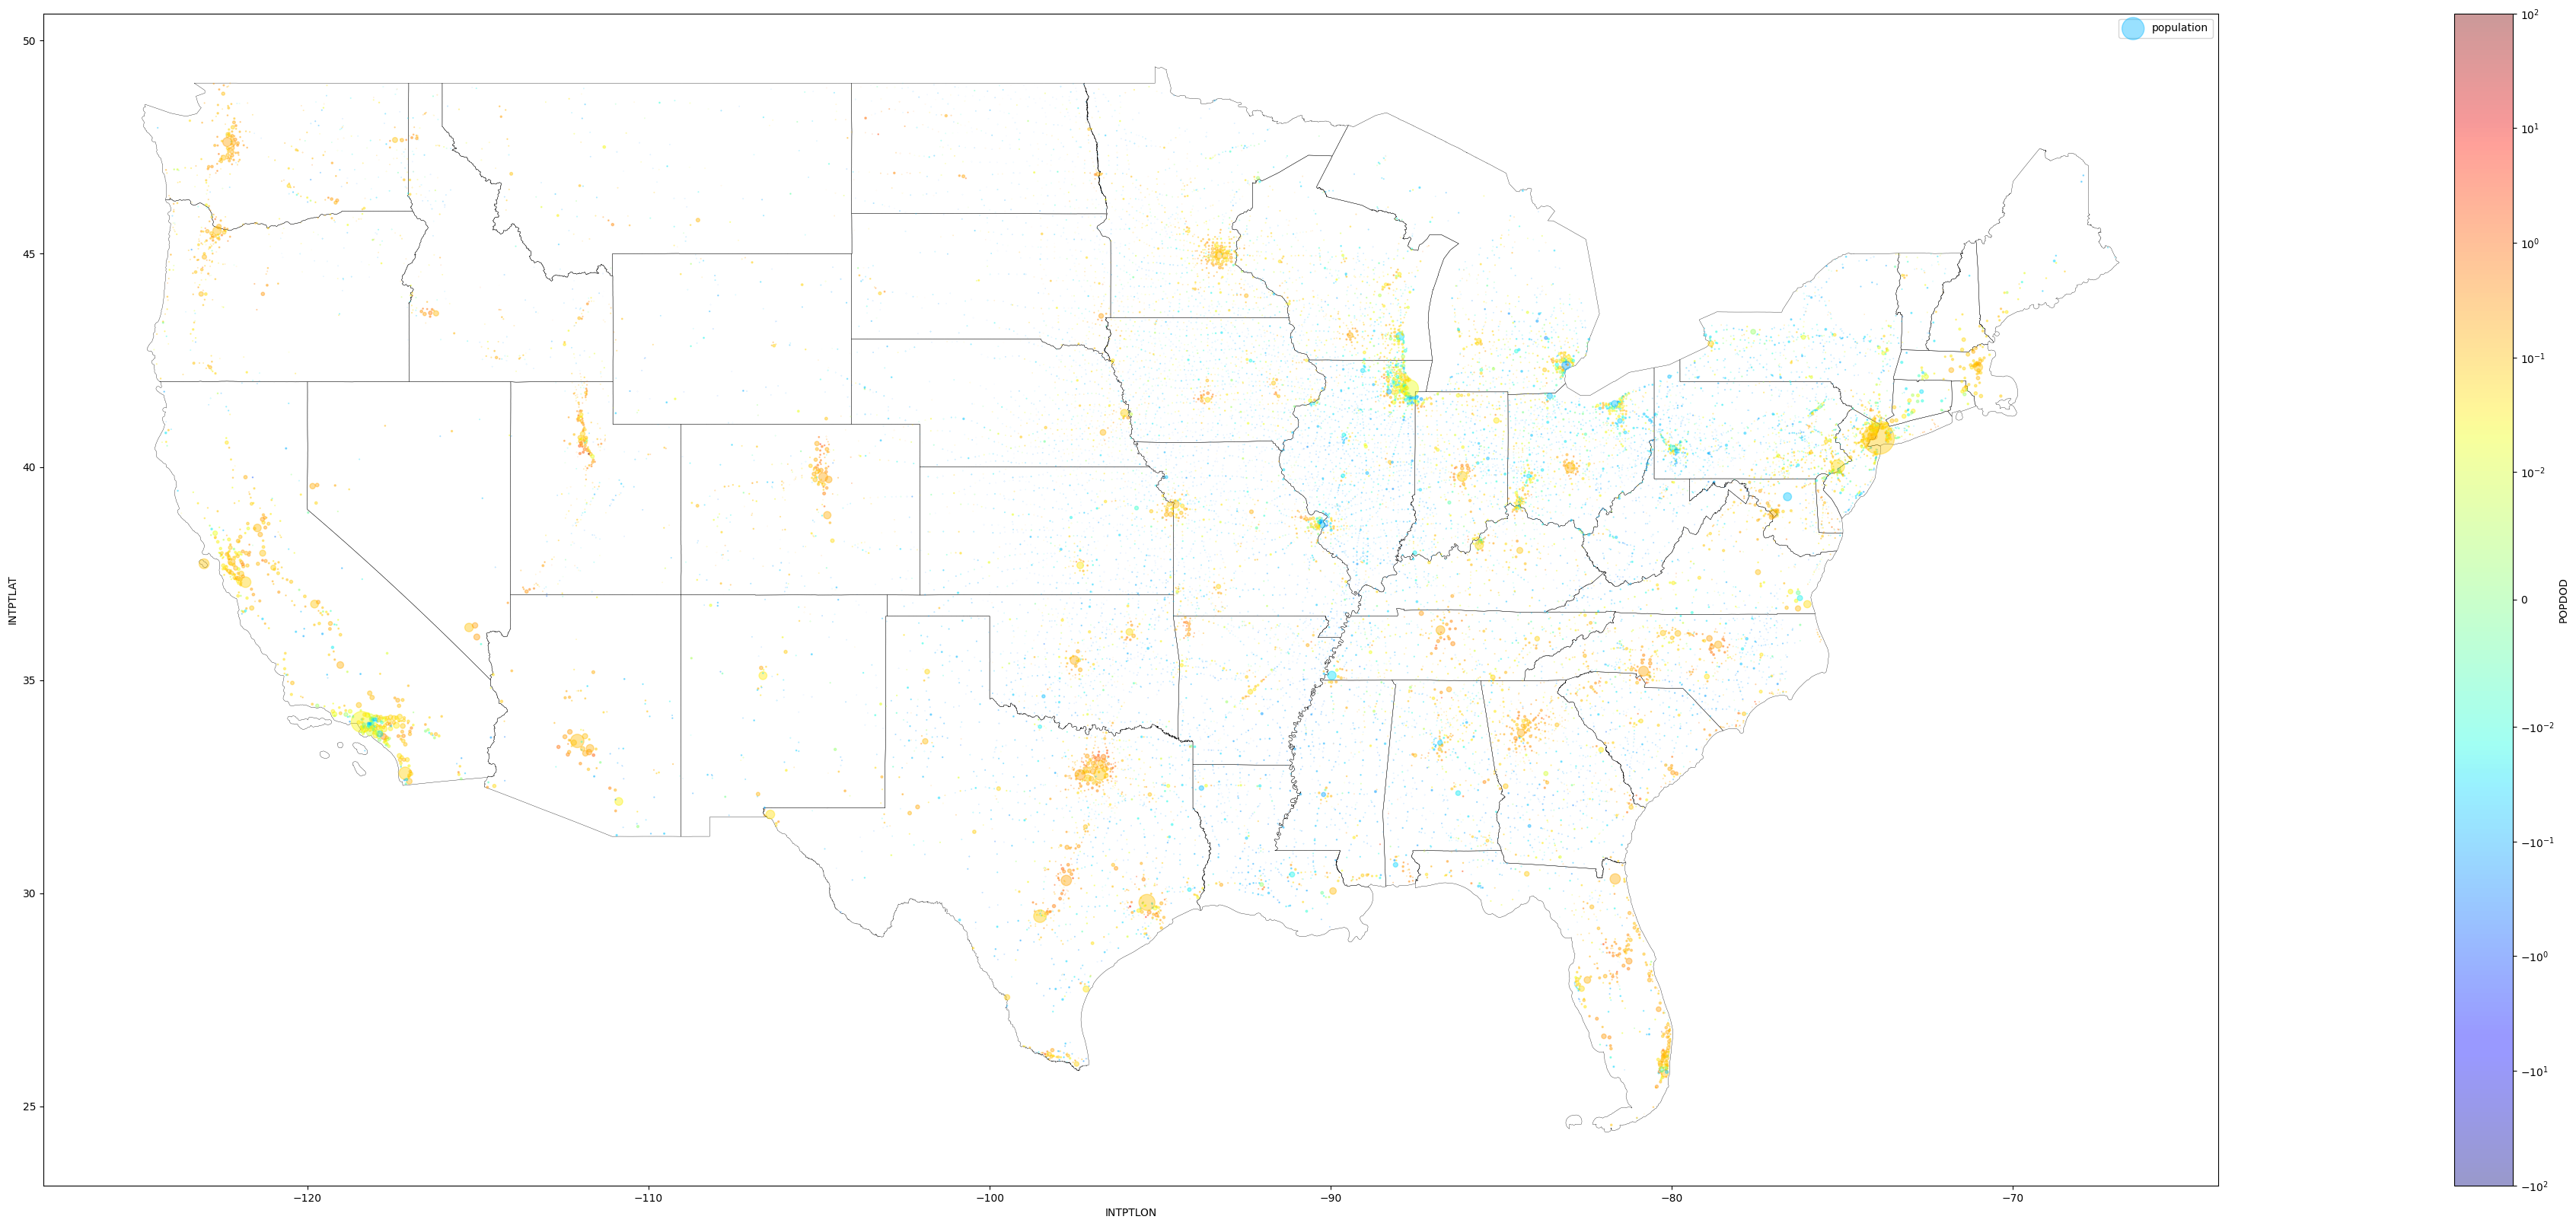

In [30]:
'''
Plot U.S. places on map.
'''
%matplotlib inline

# take only continental part of the U.S.
places_map = places[places["STUSPS"].isin(continental)]
states_map = states[states["STUSPS"].isin(continental)]

fig = plt.figure(0, figsize=(80,20)) 
plot = fig.add_subplot()

states_map.boundary.plot(
    ax=plot, zorder=1,
    linewidth=0.25, color="Black",
)

places_map.plot(
    ax=plot, zorder=2,
    kind="scatter", x="INTPTLON", y="INTPTLAT", alpha=0.4,
    s=places_map["POPBASE"].astype("float64")/10000, label="population",
    c="POPDOD", cmap="jet", norm=colors.SymLogNorm(linthresh=0.01, vmin=-100, vmax=100, base=10), colorbar=True,
)
